In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

In [2]:
y, sr = librosa.load('pitch.wav')
ipd.Audio(y, rate = sr)

In [3]:
y.shape

(46848,)

In [4]:
import librosa.display

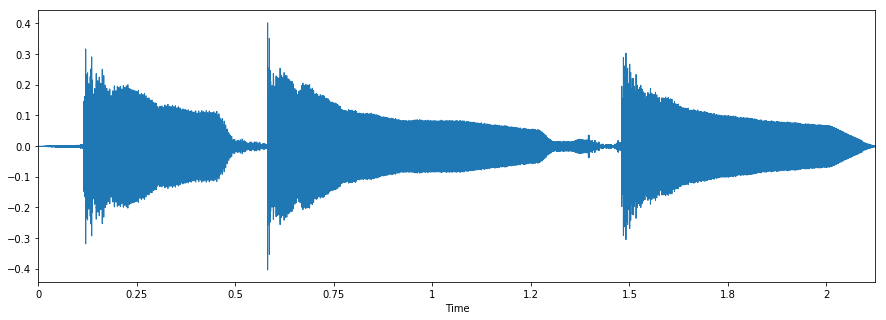

In [5]:
plt.figure(figsize = (15, 5))
librosa.display.waveplot(y, sr = sr)

<font size = "6"> <b> Time domain Onset Detection

In [6]:
# Setting up parameters
hop_size = 256
frame_size = 512

In [23]:
import librosa.feature

In [24]:
rmse = librosa.feature.rmse(y, frame_length = frame_size, hop_length = hop_size).flatten()

In [25]:
rmse.size

184

In [26]:
# Calculating energy
energy = np.array([
    sum(abs(y[i:i+frame_size]**2/float(frame_size)))
    for i in range(0, y.size, hop_size)
])

In [27]:
energy.size

183

In [28]:
frames_energy = range(len(energy))
t_energy = librosa.frames_to_time(frames_energy, sr = sr, hop_length = hop_size)

frames_rmse = range(len(rmse))
t_rmse = librosa.frames_to_time(frames_rmse, sr = sr, hop_length = hop_size)

frames_total = range(len(y))
time = librosa.frames_to_time(frames_total, sr = sr, hop_length = 1)

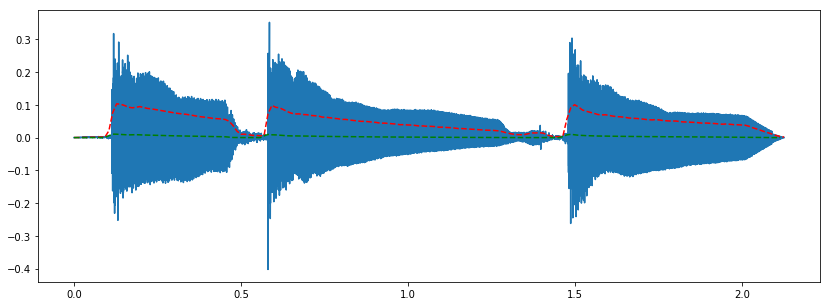

In [30]:
plt.figure(figsize = (14, 5))
plt.plot(time, y, t_rmse, rmse, 'r--', t_energy, energy, 'g--')

In [31]:
energy.max()

0.010630594090216078

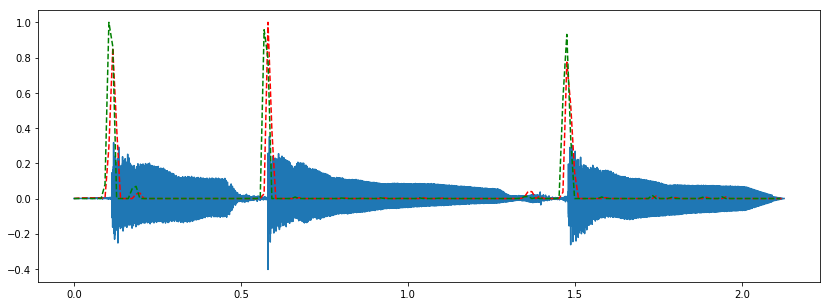

In [33]:
rmse_diff = np.zeros_like(rmse)
rmse_diff[1:] = np.diff(rmse)
# Half wave rectification
rmse_diff = np.max([rmse_diff, np.zeros_like(rmse_diff)], axis = 0)
rmse_diff = rmse_diff/max(rmse_diff)

energy_diff = np.zeros_like(energy)
energy_diff[1:] = np.diff(energy)
energy_diff = np.max([energy_diff, np.zeros_like(energy_diff)], axis = 0)
energy_diff = energy_diff/max(energy_diff)

frames_rmse_diff = range(len(rmse_diff))
t_rmse_diff = librosa.frames_to_time(frames_rmse_diff, sr = sr, hop_length = hop_size)

frames_energy_diff = range(len(energy_diff))
t_energy_diff = librosa.frames_to_time(frames_energy_diff, sr = sr, hop_length = hop_size)

plt.figure(figsize = (14, 5))
plt.plot(time, y, t_rmse_diff, rmse_diff, 'r--', t_energy_diff, energy_diff, 'g--')

In [34]:
# Converting energies to log scale
log_rmse = np.log(rmse)
log_energy = np.log(energy)

In [38]:
log_rmse_diff = np.zeros_like(log_rmse)
log_rmse_diff[1:] = np.diff(log_rmse)
# Half wave rectification
log_rmse_diff = np.max([log_rmse_diff, np.zeros_like(log_rmse_diff)], axis = 0)
log_rmse_diff = log_rmse_diff/max(log_rmse_diff)

log_energy_diff = np.zeros_like(log_energy)
log_energy_diff[1:] = np.diff(log_energy)
log_energy_diff = np.max([log_energy_diff, np.zeros_like(log_energy_diff)], axis = 0)
log_energy_diff = log_energy_diff/max(log_energy_diff)

log_frames_diff_rmse = range(len(log_rmse_diff))
log_t_diff_rmse = librosa.frames_to_time(log_frames_diff_rmse, sr = sr, hop_length = hop_size)

log_frames_diff_energy = range(len(log_energy_diff))
log_t_diff_energy = librosa.frames_to_time(log_frames_diff_energy, sr = sr, hop_length = hop_size)

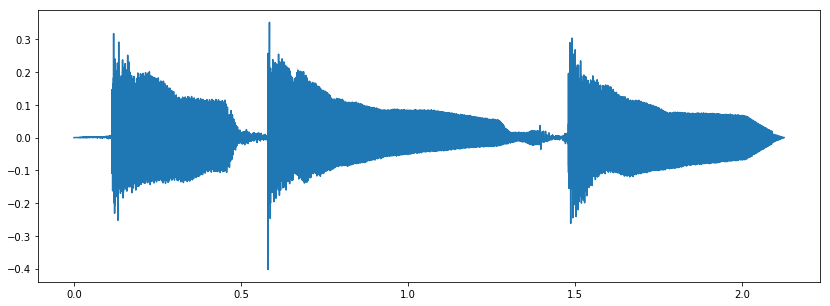

In [39]:
plt.figure(figsize = (14, 5))

plt.plot(time, y)

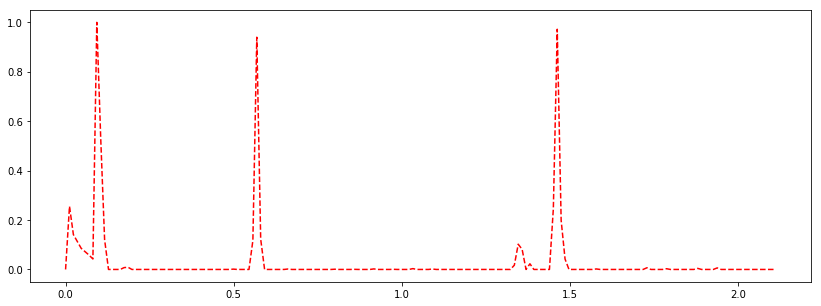

In [40]:
plt.figure(figsize = (14, 5))
plt.plot(log_t_diff_energy, log_energy_diff, 'r--')

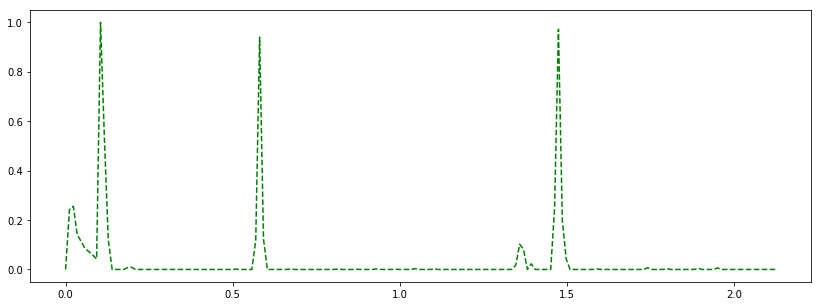

In [41]:
plt.figure(figsize = (14, 5))
plt.plot(log_t_diff_rmse, log_rmse_diff, 'g--')

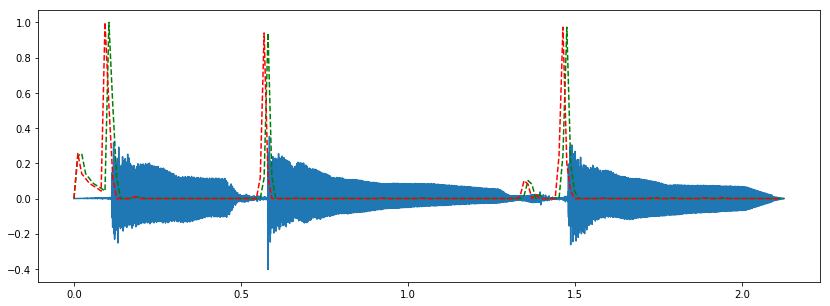

In [43]:
plt.figure(figsize = (14, 5))
plt.plot(time, y, log_t_diff_rmse, log_rmse_diff, 'g--', log_t_diff_energy, log_energy_diff, 'r--')

<font size = '6'> <b> Spectral flux based onset detection

In [3]:
def fft_mag(x):
    # Analysis of a signal using the discrete Fourier transform
    # x: input signal, w: analysis window, N: FFT size 
    # returns spectrum of the block
    
    # Size of positive side of fft
    blockSize = len(x)
    
    # Define window
    w = np.hanning(blockSize)
    w = w/np.sum(w)
    
    x = x*w
    
    relevant = (blockSize//2)+1
    h1 = (blockSize+1)//2
    h2 = blockSize//2
    
    # Arrange audio to center the fft around zero
    x_arranged = np.zeros(blockSize)                         
    x_arranged[:h1] = x[h2:]                              
    x_arranged[-h2:] = x[:h2]
    
    # compute fft and keep the relevant part
    X = np.fft.fft(x_arranged)[:relevant]
    
    # compute magnitude spectrum in dB
    magX = abs(X)
    
    return magX

def compute_stft(xb):
    # Generate spectrogram
    # returns magnitude spectrogram

    blockSize = xb.shape[1]
    hopSize = blockSize//2
    
    mag_spectrogram = np.zeros((xb.shape[0], xb.shape[1]//2+1))
    for i, block in enumerate(xb):
        mag_spectrogram[i] = fft_mag(block)
    return mag_spectrogram

def plot_spectrogram(spectrogram, fs, hopSize):
    
    t = hopSize*np.arange(spectrogram.shape[0])/fs
    f = np.arange(0,fs/2, fs/2/spectrogram.shape[1])

    plt.figure(figsize = (15, 7))
    plt.xlabel('Time (s)')
    plt.ylabel('Freq (Hz)')
    plt.pcolormesh(t, f, spectrogram.T)
    plt.show()

In [4]:
def extract_spectral_flux(x, blockSize, hopSize, fs):    
    # Returns an array (NumOfBlocks X k) of spectral flux for all the audio blocks: k = frequency bins
    # xb is a matrix of blocked audio data (dimension NumOfBlocks X blockSize)
    
    xb = block_audio(x, blockSize, hopSize, fs)
    X = compute_stft(xb)
    
    # Compute spectral flux
    # Initialise blockNum and freqIndex
    n = 0
    k = 0

    spectral_flux = np.zeros(xb.shape[0])

    for n in np.arange(X.shape[0]-1):
        flux_frame = 0
        for k in np.arange(X.shape[1]):
            flux = (abs(X[n+1, k]) - abs(X[n, k]))**2
            flux_frame += flux
        flux_frame = np.sqrt(flux_frame)/(xb.shape[1]//2+1)
        spectral_flux[n] = flux_frame
    spectral_flux = np.array(spectral_flux)
    
    # Half wave rectification
    envelope = np.max([spectral_flux, np.zeros_like(spectral_flux)], axis = 0)
    envelope = envelope/max(envelope)

    return spectral_flux, envelope

In [6]:
## High frequency content

In [7]:
def HFC(x, w, blockSize, hopSize):
    """
    Onset detection using High Frequency Content
    x: input array sound, w: analysis window
    returns Energy: Matrix containing sum(K * mX**2)/N for all frames
    """

    M = w.size                    
    h1 = (w.size + 1) // 2        
    h2 = w.size // 2              
    x = np.append(np.zeros(h2), x)
    x = np.append(x, np.zeros(h2))
    start = h1                     
    end = x.size - h1           
    w = w / sum(w)               
    Energy = []                  
    frame_frequencies = np.arange(blockSize // 2 + 1)
    while start <= end:           
        x1 = x[start - h1:start + h2]
        mX = fft_mag(x1)
        energy_frame = mX * mX * frame_frequencies
        hfc_frame = sum(energy_frame) / blockSize
        Energy.append(hfc_frame)
        start += hopSize
    Energy = np.array(Energy)                           
    return Energy

## Spectral flux using librosa

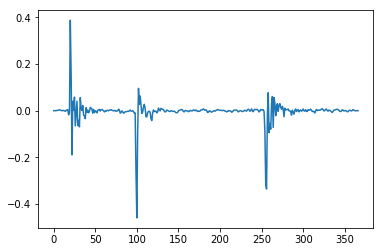

In [12]:
plt.plot(X[100])

In [8]:
# Logarithmic Compression for better interpretation
S = np.log1p(10 * abs(X))

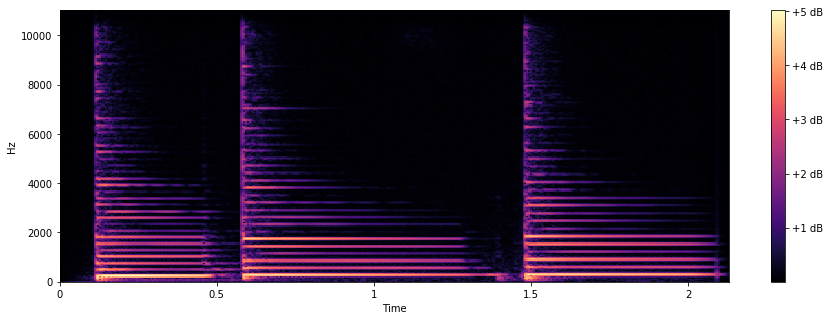

In [9]:
plt.figure(figsize = (15, 5))
librosa.display.specshow(S, sr = sr, hop_length = hop_length, x_axis = 'time', y_axis = 'linear')
plt.colorbar(format = '%+2.0f dB')

In [47]:
# Spectral flux calculation : Delta(n) = sum(S(n+1, k) - S(n, k)) for all k
frame_flux = np.array([])
for frame in np.arange(S.shape[1]-1):
    sum = 0
    for freq in np.arange(S.shape[0]-1):
        flux = S[freq, frame + 1] - S[freq, frame]
        sum = flux + sum
    frame_flux = np.append(frame_flux, sum)

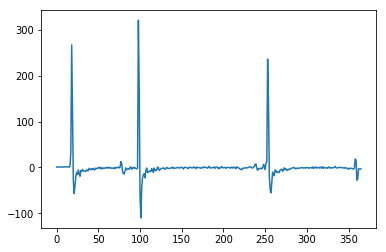

In [48]:
plt.plot(frame_flux)

In [49]:
# Half wave rectification
envelope = np.max([frame_flux, np.zeros_like(frame_flux)], axis = 0)
envelope_norm = envelope/max(envelope)

In [50]:
flux_time = np.arange(0, y.size/float(sr), y.size/float(sr)/len(envelope))

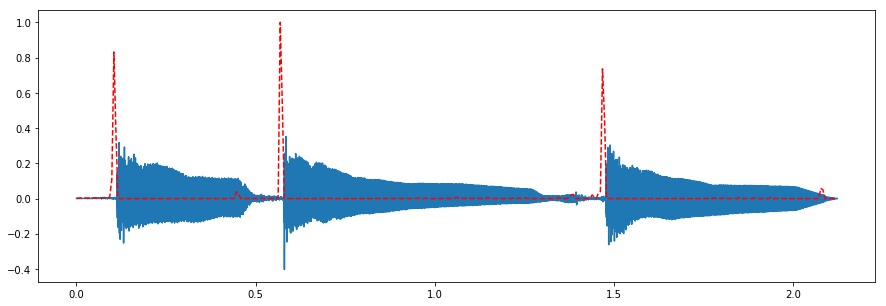

In [51]:
plt.figure(figsize = (15, 5))
plt.plot(time, y, flux_time, envelope_norm, 'r--')

<font size = 6> <b> Phase based novelty

In [52]:
phase = np.angle(X)
phase = np.unwrap(phase)

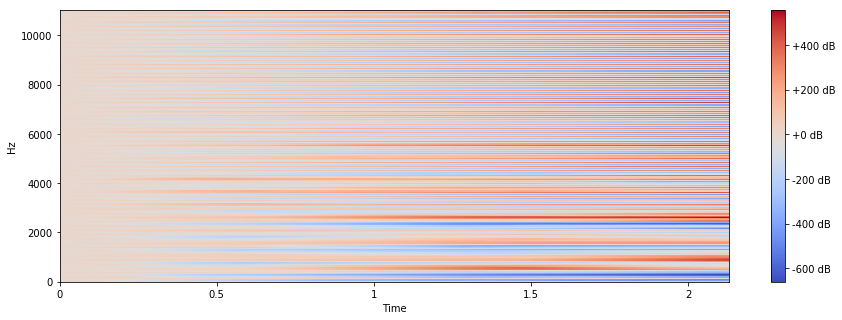

In [53]:
plt.figure(figsize = (15, 5))
librosa.display.specshow(phase, sr = sr, hop_length = hop_length, x_axis = 'time', y_axis = 'linear')
plt.colorbar(format = '%+2.0f dB')

In [54]:
phase.shape

(257, 367)

In [55]:
phase.size

94319

In [56]:
phase_d1 = np.diff(phase)
phase_d1

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -3.1415925 ,  3.1415925 ],
       [-0.76564503,  0.41262913,  0.06492257, ...,  2.76721954,
         2.8170166 ,  1.97634888],
       [ 1.4562875 ,  1.16452307, -1.48233706, ...,  2.16888428,
         2.49813843, -0.99713135],
       ...,
       [-1.32520425,  2.41683638,  2.45080829, ...,  2.71075439,
         1.01309204,  1.15930176],
       [ 0.36286774, -1.28712299, -0.65932059, ..., -1.43063354,
         1.98492432, -1.24777222],
       [ 0.        ,  0.        , -3.1415925 , ...,  0.        ,
         0.        ,  0.        ]])

In [57]:
phase_d2 = np.diff(phase_d1)
phase_d2

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -3.1415925 ,  6.28318501],
       [ 1.17827415, -0.34770656, -0.03764939, ...,  0.04637909,
         0.04979706, -0.84066772],
       [-0.29176444, -2.64686012,  1.8605091 , ..., -0.8659668 ,
         0.32925415, -3.49526978],
       ...,
       [ 3.74204063,  0.03397191,  0.40512347, ...,  5.00250244,
        -1.69766235,  0.14620972],
       [-1.64999074,  0.6278024 , -1.58958471, ..., -1.3522644 ,
         3.41555786, -3.23269653],
       [ 0.        , -3.1415925 ,  6.28318501, ..., -3.1415925 ,
         0.        ,  0.        ]])

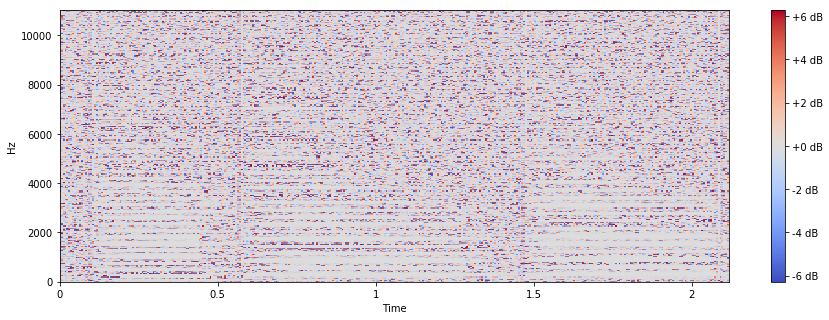

In [58]:
plt.figure(figsize = (15, 5))
librosa.display.specshow(phase_d2, sr = sr, hop_length = hop_length, x_axis = 'time', y_axis = 'linear')
plt.colorbar(format = '%+2.0f dB')

In [59]:
frame_phase = np.array([])

In [60]:
for i in np.arange(phase_d2.shape[1]):
                   frame_phase = np.append(frame_phase, np.sum(abs(phase_d2[:, i])))
frame_phase

array([453.99802195, 417.28567161, 351.72851838, 333.4997395 ,
       350.11358927, 383.1412872 , 359.27343529, 393.77270547,
       358.66437972, 393.57567451, 423.0783457 , 391.52212653,
       378.52277479, 358.1020918 , 440.86263887, 398.71368313,
       529.95577995, 484.98740105, 305.80408761, 235.07871352,
       350.48076067, 381.67543557, 338.33879588, 305.42514448,
       343.05837668, 332.24858772, 325.8220963 , 319.01766348,
       334.27496796, 332.36924476, 297.49153217, 322.59933123,
       351.66091333, 364.72107064, 321.06700765, 320.67799152,
       316.91693025, 320.62225136, 305.68056757, 319.87116994,
       297.71524574, 310.14791109, 296.70871405, 307.44848763,
       290.0999705 , 287.74848687, 347.34876917, 335.05034882,
       269.62372249, 296.49860542, 309.47205389, 344.74232845,
       345.33873153, 317.90742672, 310.18375778, 308.89057691,
       313.19077611, 317.89788497, 298.61691283, 277.06986918,
       334.68729071, 343.58118279, 345.61438653, 351.29

In [61]:
frame_phase.size

365

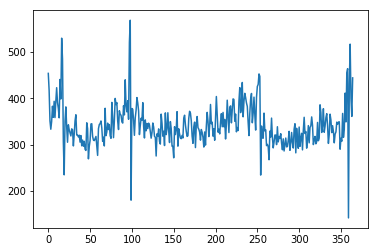

In [62]:
plt.plot(frame_phase)

In [63]:
# Smoothening and segregating peaks
M = 5
wind = np.ones(M)      # Smoothening window
wind = wind/M
wind

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [64]:
d2_avg = np.array([])
for i in np.arange(M//2, frame_phase.size-M//2, 1):
    local_avg = np.sum(frame_phase[i-M//2:i+M//2 + 1] * wind)
    d2_avg = np.append(d2_avg, local_avg)

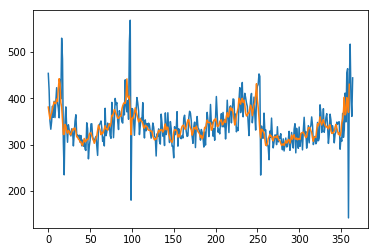

In [65]:
plt.plot(frame_phase)
plt.plot(d2_avg)

In [66]:
# Adding extra elements to d2 to ensure similar matrix shapes
d2_avg = np.append(d2_avg[0], d2_avg)
d2_avg = np.append(d2_avg[0], d2_avg)
d2_avg = np.append(d2_avg, d2_avg[d2_avg.size-1])
d2_avg = np.append(d2_avg, d2_avg[d2_avg.size-1])

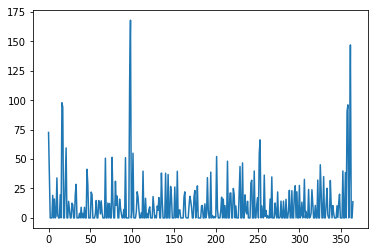

In [67]:
# Peak segregation
peaks = frame_phase - d2_avg

# Half wave rectification
peaks = np.max([peaks, np.zeros_like(peaks)], axis = 0)
plt.plot(peaks)

In [68]:
time_phase = np.arange(0, y.size/float(sr), y.size/float(sr)/peaks.size)

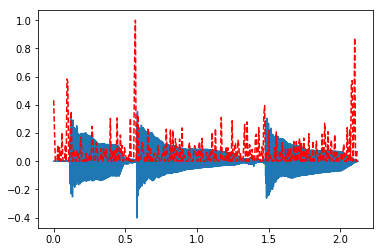

In [69]:
peaks = peaks/max(peaks)
plt.plot(time, y, time_phase, peaks, 'r--')